In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from scipy.stats import multivariate_normal


# you can choose one of the following package for image reading/processing

import cv2
import PIL


**1. Support Vector Machine**

In [2]:
data = pd.read_csv("./x_train.csv",header= None)/255
label = pd.read_csv("./t_train.csv",header= None)

data_numpy=data.to_numpy()
label_numpy=label.to_numpy()

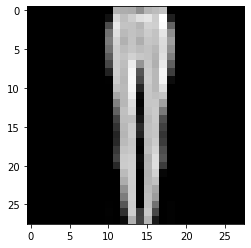

In [3]:
plt.imshow(data_numpy[0].reshape((28,28)),cmap="gray")

In [4]:
def PCA(data, d):
  new_data = data - np.mean(data, axis=0)
  U, Sigma, Vh = np.linalg.svd(new_data.T)
  pca_data = np.dot(new_data, U[:,:d])
  return pca_data

9.31193515001204
-7.454836130684056


In [5]:
data_pca=PCA(data_numpy,2)
clf=svm.SVC(kernel='linear',degree=2,C=1,decision_function_shape='ovo')
clf.fit(data_pca,label.to_numpy().ravel())
#print(clf.score(data_pca,label.to_numpy().ravel()))

0.95


In [6]:
c=(clf.dual_coef_)
v=(clf.support_vectors_)

print(clf.n_support_)
print(clf.dual_coef_)
print(clf.coef_)

[20 15  5]
[[ 0.39870924  1.          1.          0.          0.          1.
   1.          0.          1.          1.          0.66239456  1.
   1.          0.          1.          1.          1.          1.
   0.          1.         -1.         -0.0611038  -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -0.80991859 -1.         -1.        ]
 [ 0.          0.          0.          1.          0.42636621  0.
   0.          1.          0.          0.          1.          0.
   0.          0.38355238  0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.74455993  0.          0.          0.         -0.52069471
  -0.22386522 -0.         -0.         -0.        ]]
[[-0.11943642 -0.71770762]
 [ 0.98189889  1.14167465]
 [ 0.70406366  0.99662907]]


In [75]:
def linear_kernel(x1,x2):
    return (x1.reshape(1,-1)@x2.reshape(-1,1)).item()
def linear_phi(x):
    return x
def poly_phi(x):
    x1,x2=x
    return np.array([x1**2,1.4142135*x1*x2,x2**2])
def poly_kernel(x1,x2):
    return ((x1.reshape(1,-1)@x2.reshape(-1,1)).item())**2

In [60]:
poly_phi(np.array([2,3]))

array([4.      , 8.485281, 9.      ])

In [8]:
#index 0 for 0v1, 1 for 0v2 2 for 1v2
v=(clf.support_vectors_)
[len_0,len_1,len_2]=clf.n_support_

"""
#ndarray
vector_0=v[0:len_0]
vector_1=v[len_0:(len_0+len_1)]
vector_2=v[-5:]
"""
#list
vector_0=[i for i in v[0:len_0]]
vector_1=[i for i in v[len_0:(len_0+len_1)]]
vector_2=[i for i in v[-5:]]
support_vectors=[vector_0,vector_1,vector_2]

dual_coef=clf.dual_coef_
alpha_01=dual_coef[0][0:(len_0+len_1)]
alpha_02=np.concatenate([dual_coef[1][0:len_0],dual_coef[0][-len_2:]])
alpha_12=np.concatenate([dual_coef[1][len_0:(len_0+len_1)],dual_coef[1][-len_2:]])
alpha_list=[alpha_01,alpha_02,alpha_12]





In [9]:
#index 0 for 0v1, 1 for 0v2 2 for 1v2
def get_weight(alpha_list,support_vectors,kernel="linear"):
    if kernel=="linear":
        kernel=linear_kernel
        phi=linear_phi
    else:
        kernel=poly_kernel
        phi=poly_phi
    weight_list=[0]*3
    #model0 0v1
    for i,vec in enumerate(support_vectors[0]+support_vectors[1]):
        weight_list[0]+=(phi(vec)*alpha_list[0][i])
    #model1 0v2
    for i,vec in enumerate(support_vectors[0]+support_vectors[2]):
        weight_list[1]+=(phi(vec)*alpha_list[1][i])
    #model2 1v2
    for i,vec in enumerate(support_vectors[1]+support_vectors[2]):
        weight_list[2]+=(phi(vec)*alpha_list[2][i])
    return weight_list
weight_list=get_weight(alpha_list,support_vectors,kernel="linear")
print(weight_list)
#print(clf.coef_) #for check

[array([-0.11943642, -0.71770762]), array([0.98189889, 1.14167465]), array([0.70406366, 0.99662907])]
[[-0.11943642 -0.71770762]
 [ 0.98189889  1.14167465]
 [ 0.70406366  0.99662907]]


In [10]:
#M for <1
#S for <=1
def get_bias(alpha_list,support_vectors,kernel="linear"):
    if kernel=="linear":
        kernel=linear_kernel
        phi=linear_phi
    else:
        kernel=poly_kernel
        phi=poly_phi
    bias_list=[0]*3
    subset_list=[support_vectors[0]+support_vectors[1],
                 support_vectors[0]+support_vectors[2],
                 support_vectors[1]+support_vectors[2]]
    #model 0 for 0v1, 1 for 0v2 2 for 1v2
    for model, subset in enumerate(subset_list):     
        countM=0
        for i,vec1 in enumerate(subset):
            if alpha_list[model][i]==0:
                continue
            if abs(alpha_list[model][i])==1: #M for 0< <1
                continue
            countM+=1
            tn=np.sign(alpha_list[model][i]) 
            S_sum=0
            for j,vec2 in enumerate(subset): #S for <=1
                S_sum+=(kernel(vec1,vec2)*alpha_list[model][j])
            bias_list[model]+=tn-S_sum.item() 
        bias_list[model]/=countM
    return bias_list
"""
    #model1 0v2
    for i,vec in enumerate(support_vectors[0]+support_vectors[2]):
        weight_list[1]+=(phi(vec)*alpha_list[1][i])
    #model2 1v2
    for i,vec in enumerate(support_vectors[1]+support_vectors[2]):
        weight_list[2]+=(phi(vec)*alpha_list[2][i])
"""

bias_list=get_bias(alpha_list,support_vectors,kernel="linear")
print(bias_list)
#print(clf.intercept_) #for check

[0.8682406263188275, 4.496885214706241, 1.8412193321151558]
[0.86823817 4.49688563 1.84121932]


In [55]:
def predict(X,weight_list,bias_list):
    N=len(X)
    vote=np.zeros((N,3))
    y0=weight_list[0].reshape(1,-1)@X.T+bias_list[0]  #1,300
    y1=weight_list[1].reshape(1,-1)@X.T+bias_list[1]
    y2=weight_list[2].reshape(1,-1)@X.T+bias_list[2]
    for i in range(N):
        if y0[0][i]>0:
            vote[i][0]+=1
        else:
            vote[i][1]+=1
        if y1[0][i]>0:
            vote[i][0]+=1
        else:
            vote[i][2]+=1
        if y2[0][i]>0:
            vote[i][1]+=1
        else:
            vote[i][2]+=1
    return np.argmax(vote,axis=1)

In [12]:
#reference:https://github.com/andy6804tw/2021-13th-ironman/blob/main/11.SVM/11.1.SVM(Classification-iris).ipynb
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_supportvector(ax,X0,X1,support_list):
    X0_support=[X0[i] for i in support_list]
    X1_support=[X1[i] for i in support_list]
    ax.scatter(X0_support, X1_support, c="white", s=20,marker="o")
    

In [25]:
subdata_list=[]
for i in range(3):
    index=np.where(label_numpy.reshape(-1) == i)
    subdata_list.append(data_pca[index])

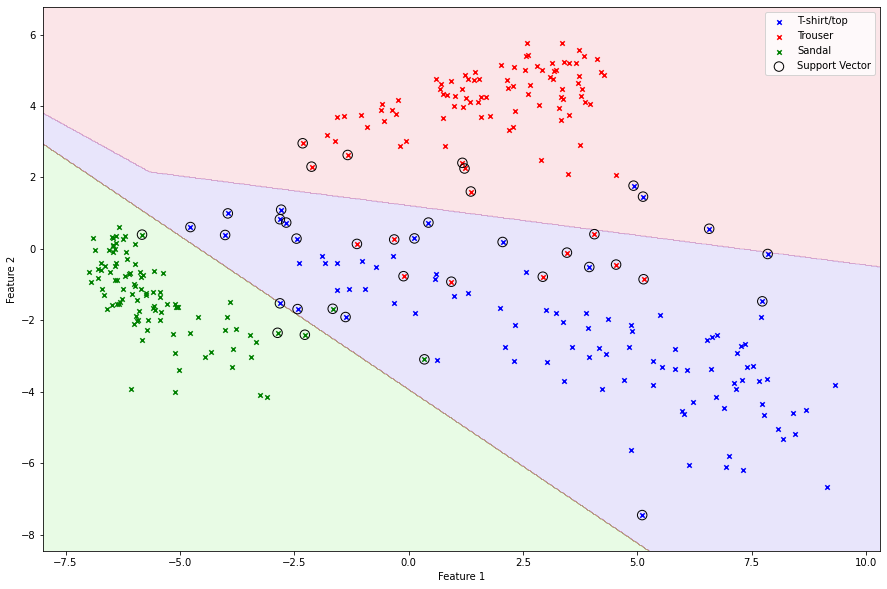

In [57]:
X0, X1 = data_pca[:, 0], data_pca[:, 1]
x_, y_ = make_meshgrid(X0, X1) #坐標軸每個點(顏色解析度) ex:在(10,10)中平均取1000或10000個點
#cotour
points=np.c_[x_.ravel(), y_.ravel()]
predictions=predict(points,weight_list,bias_list)

#for i in range(len(points)):
#    predictions.append(predict(points[i],weight_list,bias_list))
N,D=x_.shape
Z=np.array(predictions).reshape((N,D))
plt.contourf(x_, y_,Z,cmap=plt.cm.brg, alpha=0.1)
#scatter

plt.scatter(subdata_list[0][:,0], subdata_list[0][:,1],s=20, c='b', marker='x', label="T-shirt/top")
plt.scatter(subdata_list[1][:,0], subdata_list[1][:,1],s=20, c='r', marker='x', label="Trouser")
plt.scatter(subdata_list[2][:,0], subdata_list[2][:,1],s=20, c='g', marker='x', label="Sandal")
plt.scatter(v[:,0], v[:,1],s=90, facecolors='none', edgecolors='k', linewidths=1,label="Support Vector")

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('SVM (linear kernel)')
fig = plt.gcf()
fig.set_size_inches(15, 10)


In [78]:
clf=svm.SVC(kernel='poly',degree=2,C=1,decision_function_shape='ovo')
clf.fit(data_pca,label.to_numpy().ravel())
#print(clf.score(data_pca,label.to_numpy().ravel()))
print(clf.n_support_)

0.8833333333333333
[47 48 37]


In [79]:
#index 0 for 0v1, 1 for 0v2 2 for 1v2
v=(clf.support_vectors_)
[len_0,len_1,len_2]=clf.n_support_

"""
#ndarray
vector_0=v[0:len_0]
vector_1=v[len_0:(len_0+len_1)]
vector_2=v[-5:]
"""
#list
vector_0=[i for i in v[0:len_0]]
vector_1=[i for i in v[len_0:(len_0+len_1)]]
vector_2=[i for i in v[-len_2:]]
support_vectors=[vector_0,vector_1,vector_2]

dual_coef=clf.dual_coef_
alpha_01=dual_coef[0][0:(len_0+len_1)]
alpha_02=np.concatenate([dual_coef[1][0:len_0],dual_coef[0][-len_2:]])
alpha_12=np.concatenate([dual_coef[1][len_0:(len_0+len_1)],dual_coef[1][-len_2:]])
alpha_list=[alpha_01,alpha_02,alpha_12]

In [80]:
weight_list=get_weight(alpha_list,support_vectors,kernel="poly")
bias_list=get_bias(alpha_list,support_vectors,kernel="poly")
print(weight_list)
print(bias_list) 

[array([ 20.68556111, -76.44761197, -99.09738118]), array([ -57.51112119, -105.06438722,  -12.71266284]), array([-74.1673779 , -24.24748632,  72.35598938])]
[368.23043605123195, 939.861511053441, 649.5093299847211]


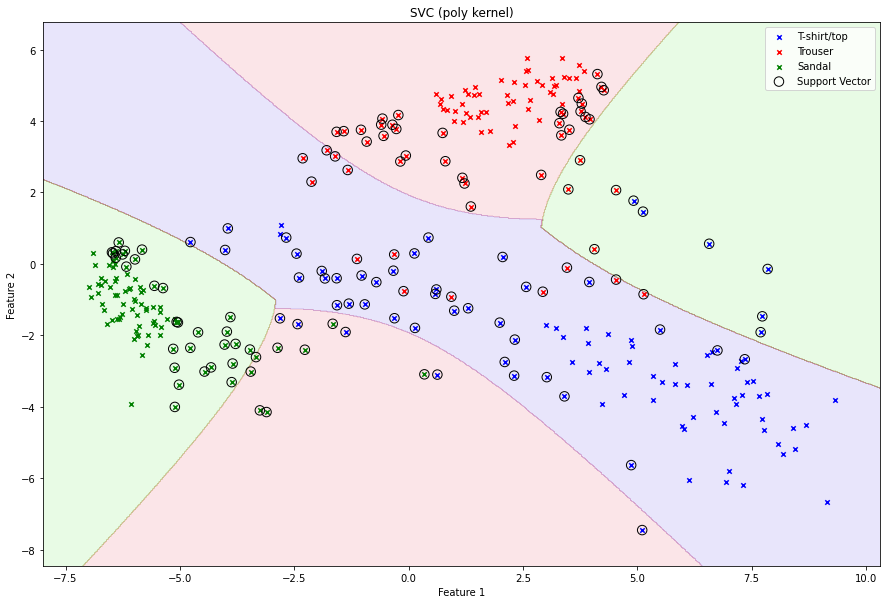

In [82]:
X0, X1 = data_pca[:, 0], data_pca[:, 1]
x_, y_ = make_meshgrid(X0, X1) #坐標軸每個點(顏色解析度) ex:在(10,10)中平均取1000或10000個點
#cotour
points=np.c_[x_.ravel()*x_.ravel(),1.4142135*x_.ravel()*y_.ravel() ,y_.ravel()*y_.ravel()]
predictions=predict(points,weight_list,bias_list)

#for i in range(len(points)):
#    predictions.append(predict(points[i],weight_list,bias_list))
N,D=x_.shape
Z=np.array(predictions).reshape((N,D))
plt.contourf(x_, y_,Z,cmap=plt.cm.brg, alpha=0.1)
#scatter

plt.scatter(subdata_list[0][:,0], subdata_list[0][:,1],s=20, c='b', marker='x', label="T-shirt/top")
plt.scatter(subdata_list[1][:,0], subdata_list[1][:,1],s=20, c='r', marker='x', label="Trouser")
plt.scatter(subdata_list[2][:,0], subdata_list[2][:,1],s=20, c='g', marker='x', label="Sandal")
plt.scatter(v[:,0], v[:,1],s=90, facecolors='none', edgecolors='k', linewidths=1,label="Support Vector")

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('SVM (poly kernel)')
fig = plt.gcf()
fig.set_size_inches(15, 10)

In [74]:
t=np.array([5,2,1])
t*t

array([25,  4,  1])

**2. Gaussian Mixture Model**

In [4]:
img = cv2.imread("./hw3.jpg") #read into BGR

In [5]:
def dist(p1,p2):
    return np.dot(p1-p2,p1-p2)

In [10]:
def K_mean(img,K,d=3):

    means = np.zeros((K, d))
    N, M, _ = img.shape
    mean_list = [[0, 0, 0] for i in range(K)]
    sum_list = [[0, 0, 0] for i in range(K)]
    count_list = [0 for i in range(K)]
    assign_map = np.zeros((N, M))
    """
    好像太平均
    # initial assign
    for i in range(N):
        for j in range(M):
            assign_map[i][j] = i % K
            assignment = int(assign_map[i][j])  # numpy to int
            sum_list[assignment] += img[i][j]
            count_list[assignment] += 1
    mean_list = [sum_list[i]/count_list[i] for i in range(K)]
    print(mean_list)
    """
    mean_list = [np.zeros(3) for i in range(K)]
    for i in range(K):
        mean_list[i]=np.array([255/(K+1)*i]*3)
    print(mean_list)
    iteration = 50
    for t in range(iteration):
        sum_list = [np.zeros(3) for i in range(K)]
        count_list = [0 for i in range(K)]
        last_mean=mean_list
        for i in range(N):
            for j in range(M):
                cur_dist = [0 for i in range(K)]
                for k in range(K):
                    cur_dist[k] = dist(img[i][j], mean_list[k])

                assignment = np.argmin(cur_dist)
                assign_map[i][j] = assignment
                sum_list[assignment] += img[i][j]
                count_list[assignment] += 1

        mean_list = [sum_list[i]/(count_list[i]+0.000001) for i in range(K)] #in case of divide by 0
        
        cur_sum=0
        for i in range(K):
            cur_sum+=abs(np.sum(last_mean[i]-mean_list[i]))
        #print(cur_sum)
        if cur_sum==0:
            break
        last_mean=mean_list #don't need list.copy()?
        #print(mean_list)
        
    img_K=np.zeros((N,M,3))
    for i in range(N):
        for j in range(M):
            img_K[i][j]=mean_list[int(assign_map[i][j])]
    img_K=img_K.astype("int32")
    print(mean_list)
    return img_K,mean_list,assign_map
        

In [11]:
"""
img_K5=np.zeros((N,M,3))
for i in range(N):
    for j in range(M):
        img_K5[i][j]=mean_list[int(assign_map[i][j])]
img_K5=img_K5.astype("int32")
"""
img_list=[]
means_list=[]
k_list=[2,3,7]
for k in k_list:
    img_k,means,_=K_mean(img,k)
    img_list.append(img_k)
    means_list.append(means)

[array([0., 0., 0.]), array([85., 85., 85.])]
[array([37.16482634, 68.26272636, 35.27817707]), array([147.4240686 , 165.62772749, 176.97598856])]
[array([0., 0., 0.]), array([63.75, 63.75, 63.75]), array([127.5, 127.5, 127.5])]
[array([22.98903961, 54.14881041, 24.69622393]), array([ 90.04034777, 119.74985254,  84.3240055 ]), array([163.62365099, 178.06550582, 201.75619667])]
[array([0., 0., 0.]), array([31.875, 31.875, 31.875]), array([63.75, 63.75, 63.75]), array([95.625, 95.625, 95.625]), array([127.5, 127.5, 127.5]), array([159.375, 159.375, 159.375]), array([191.25, 191.25, 191.25])]
[array([16.68831563, 40.97466838, 18.5748686 ]), array([30.09196935, 72.41047105, 32.77840522]), array([ 72.01711491, 101.38777506,  59.11589242]), array([105.11669773, 139.53932649,  81.58016779]), array([102.57285626, 123.81782117, 148.77235275]), array([149.78354608, 165.97542466, 190.04678861]), array([199.20270577, 208.75511133, 229.8369689 ])]


-----------means of K=2---------
[37.16482634 68.26272636 35.27817707]
[147.4240686  165.62772749 176.97598856]
-----------means of K=3---------
[22.98903961 54.14881041 24.69622393]
[ 90.04034777 119.74985254  84.3240055 ]
[163.62365099 178.06550582 201.75619667]
-----------means of K=7---------
[16.68831563 40.97466838 18.5748686 ]
[30.09196935 72.41047105 32.77840522]
[ 72.01711491 101.38777506  59.11589242]
[105.11669773 139.53932649  81.58016779]
[102.57285626 123.81782117 148.77235275]
[149.78354608 165.97542466 190.04678861]
[199.20270577 208.75511133 229.8369689 ]


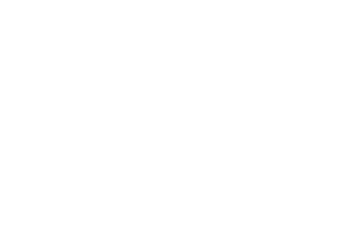

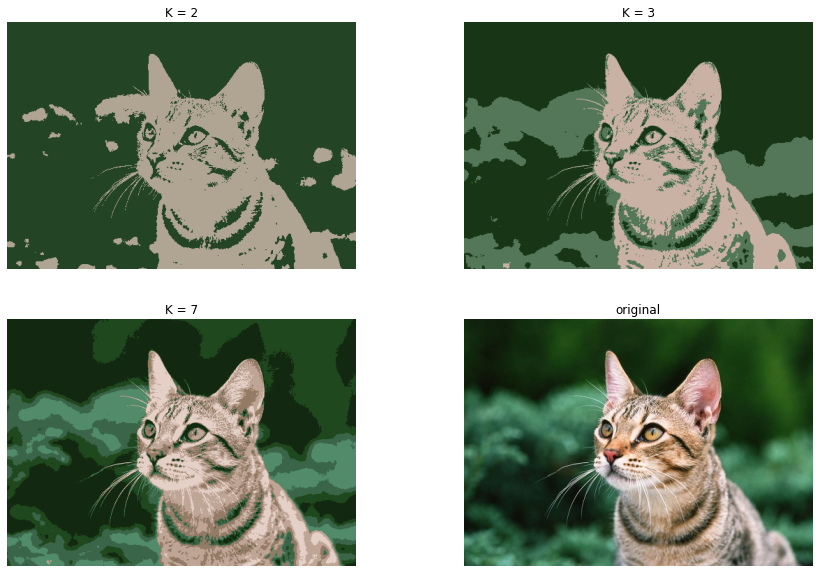

In [29]:
fig, ax = plt.subplots(2,2)

for i in range(3):
    ax[i//2,i%2].set_title("K = {}".format(k_list[i]))
    ax[i//2,i%2].imshow(img_list[i][:,:,::-1]) #BGR to RGB
    ax[i//2,i%2].axis("off")
i+=1
ax[i//2,i%2].set_title("original")
ax[i//2,i%2].imshow(img[:,:,::-1])
ax[i//2,i%2].axis("off")

fig.set_size_inches(15, 10)

cur=0
for k in k_list:
    print("-----------means of K={}---------".format(k))
    l=means_list[cur]
    for mean in l:
        print(mean)
    cur+=1


In [120]:
t=multivariate_normal.pdf([50,50,50],means_list[0][0],np.eye(3))
print(t)

def respons(x,pi_list,mean_list,cov_list): #return R(Zn~) [k=0,k=1.......]
    tmp_list=[]
    K=len(mean_list)
    cur_sum=0
    for i in range(K):
        pdf=pi_list[i]*multivariate_normal.pdf(x,mean_list[i],cov_list[i],allow_singular=True)
        tmp_list.append(pdf)
        cur_sum+=pdf
        
    cur_sum=cur_sum.item()
    if cur_sum==0:
        return [1/K]*K
    return [p/cur_sum for p in tmp_list]
def log_likelihood(img,pi_list,mean_list,cov_list):
    N,M,d=img.shape
    K=len(pi_list)
    ret=0
    for i in range(N):
        for j in range(M):
            p_sum=0
            for k in range(K):
                p_sum+=pi_list[k]*multivariate_normal.pdf(img[i][j],mean_list[k],cov_list[k],allow_singular=True)
            ret+=np.log(p_sum)
    return ret

3.4853914441925217e-157


In [185]:

def GMM(img,mean_list,K,iteration=100):
    #initial
    cov_list=[np.eye(3)*10]*K
    N, M, _ = img.shape
    pi_list = [0]*K
    data_subset=[mean for mean in mean_list]
    
    for i in range(N):
        for j in range(M):
            cur_dist = [0 for i in range(K)]
            for k in range(K):
                cur_dist[k] = dist(img[i][j], mean_list[k])
            assignment = np.argmin(cur_dist)
            pi_list[assignment]+=1
            data_subset[assignment]=np.concatenate([data_subset[assignment],img[i][j]])
    #initial covariance       
    pi_list=[pi/(N*M) for pi in pi_list]
    for k in range(K):
        tmp=data_subset[k].reshape(-1,3)
        cov_list[k]=np.cov(tmp.T)
    print(cov_list)
    #EM
    likelihood_list=[]
    for t in range(iteration):
        R_matrix=np.zeros((N*M,K))
        print(mean_list)
        #response
        for i in range(N):
            for j in range(M):
                x=img[i][j]           
                R_list=respons(x,pi_list,mean_list,cov_list)
                R_matrix[i*M+j]=np.array(R_list)

        #mean and pi
        mean_list = [np.zeros(3) for i in range(K)]
        count_list=[0 for i in range(K)]
        for i in range(N):
            for j in range(M):          
                for k in range(K):
                    mean_list[k]+=R_matrix[i*M+j][k]*img[i][j]
                    count_list[k]+=R_matrix[i*M+j][k]

        mean_list=[mean/(count_list[i]+0.0001) for i,mean in enumerate(mean_list)] #0.0001 for /0 encounter
        pi_list=count_list/sum(count_list)
  
        #cov
        cov_list=[np.zeros((3,3))]*K
        for i in range(N):
            for j in range(M):
                for k in range(K):
                    tmp_vec=img[i,j,:]-mean_list[k]
                    tmp_vec=tmp_vec.reshape((3,1))
                    cov_list[k]+=R_matrix[i*M+j][k]*(tmp_vec@tmp_vec.T)
        cov_list=[cov/(count_list[i]+0.0001) for i,cov in enumerate(cov_list)] #0.0001 for /0 encounter
        #likelihood
        likelihood_list.append(log_likelihood(img,pi_list,mean_list,cov_list))
        print("log likelihood:",likelihood_list[-1])
    return  mean_list,likelihood_list

In [103]:
K_list=[2,3,7]
GMM_means_list=[]
likelihood_list=[]
for i,k in enumerate(K_list):
    means,likeli=GMM(img,means_list[i],k)
    GMM_means_list.append(means)
    likelihood_list.append(likeli)

log likelihood: -2489861.880390595
log likelihood: -2476571.686092977
log likelihood: -2453573.187648618
log likelihood: -2431147.7912144815
log likelihood: -2423512.9340830017
log likelihood: -2422808.6629269286
log likelihood: -2422860.0101551153
log likelihood: -2422892.083721462
log likelihood: -2422900.1668011434
log likelihood: -2422901.7761107134
log likelihood: -2422902.0596061694
log likelihood: -2422902.1055864836
log likelihood: -2422902.1125713433
log likelihood: -2422902.113571968
log likelihood: -2422902.113707313
log likelihood: -2422902.1137242937
log likelihood: -2422902.1137262285
log likelihood: -2422902.1137264995
log likelihood: -2422902.1137265763
log likelihood: -2422902.1137265833
log likelihood: -2422902.113726587
log likelihood: -2422902.1137265875
log likelihood: -2422902.1137265875
log likelihood: -2422902.1137265847
log likelihood: -2422902.113726587
log likelihood: -2422902.1137265824
log likelihood: -2422902.113726584
log likelihood: -2422902.1137265824
l

ValueError: could not broadcast input array from shape (2,) into shape (3,)

[array([41.23513251, 72.81538253, 36.38676916]), array([144.38027011, 160.44415892, 183.79953011])]


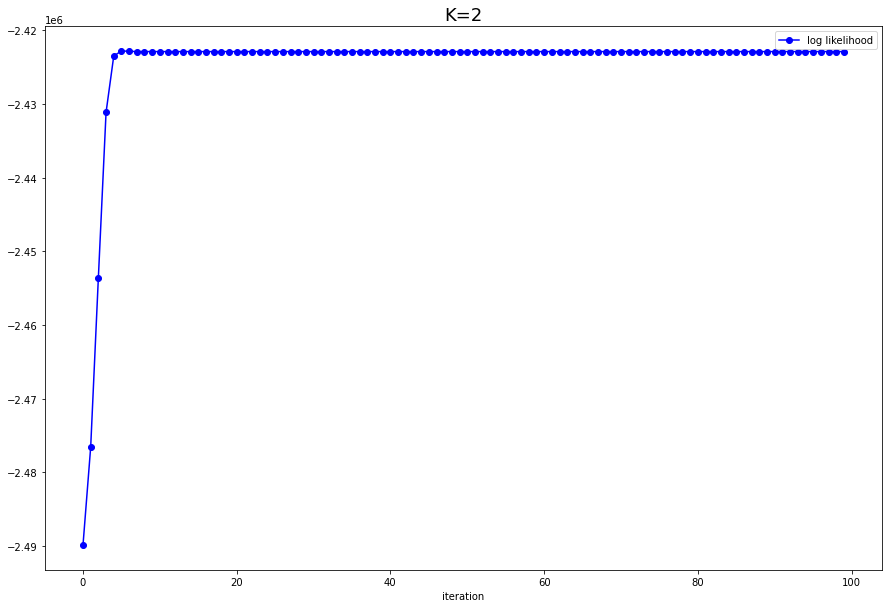

In [117]:
plt.xlabel('iteration', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('log_likelihood', fontsize="10") # 設定 y 軸標題內容及大小
plt.title('K=2', fontsize="18") # 設定圖表標題內容及大小

#likelihood_K2=[int(i) for i in likelihood_K2]
plt.plot(range(len(likelihood_list[0])),likelihood_list[0],marker='o', color='blue',label="log likelihood")
print(GMM_means_list[0])
plt.legend()
fig=plt.gcf()
fig.set_size_inches(15, 10)

In [175]:
plt.xlabel('iteration', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('log_likelihood', fontsize="10") # 設定 y 軸標題內容及大小
plt.title('K=3', fontsize="18") # 設定圖表標題內容及大小

plt.plot(range(len(likelihood_list[1])),likelihood_list[1],marker='o', color='blue',label="log likelihood")
print(GMM_means_list[1])
plt.legend()
fig=plt.gcf()
fig.set_size_inches(15, 10)

[array([[153.40651989, 150.5509262 ,  78.52195062],
       [150.5509262 , 375.72473531, 148.90037056],
       [ 78.52195062, 148.90037056, 113.59361086]]), array([[ 379.96296126,  355.76772227,  241.93810345],
       [ 355.76772227,  435.92962758,  123.68674634],
       [ 241.93810345,  123.68674634, 1070.83116741]]), array([[1098.26566019,  862.83766271,  651.01290886],
       [ 862.83766271,  776.6177183 ,  637.30520272],
       [ 651.01290886,  637.30520272,  779.53086594]])]
log likelihood: -2500797.32318448
log likelihood: -2507091.9820376663
log likelihood: -2501364.1587179597
log likelihood: -2480619.501454834
log likelihood: -2446854.623925709
log likelihood: -2426704.9625058076
log likelihood: -2422971.9037585943
log likelihood: -2422817.144061947
log likelihood: -2422875.892852767
log likelihood: -2422896.477153328
log likelihood: -2422901.076522404
log likelihood: -2422901.9402163965
log likelihood: -2422902.0866162614
log likelihood: -2422902.1096516754
log likelihood: -242

KeyboardInterrupt: 

In [ ]:
plt.xlabel('iteration', fontsize="10") # 設定 x 軸標題內容及大小
plt.ylabel('log_likelihood', fontsize="10") # 設定 y 軸標題內容及大小
plt.title('K=7', fontsize="18") # 設定圖表標題內容及大小

plt.plot(range(len(likelihood_list[2])),likelihood_list[2],marker='o', color='blue',label="log likelihood")
print(GMM_means_list[2])
plt.legend()
fig=plt.gcf()
fig.set_size_inches(15, 10)

沒用到的code

In [ ]:
subdata_list=[]
subtarget_list=[]
for i in range(3):
    subdata_list.append(data[label[0]==i])    #label==0 不行 (是dataframe不是series)
    subdata_list[i]=PCA(subdata_list[i].to_numpy(),2)
    N,D=subdata_list[i].shape
    subtarget_list.append(np.array([i for j in range(N)]))


In [ ]:
t1=data[data[3]==0]
t2=data[label[0]==0] #label==0 不行 (是dataframe不是series)
t3=(data[3]==0)
t4=(label[0]==0)


In [ ]:
#Using full Matrix multiplication is more appropriate
def predict(x,weight_list,bias_list):
    vote=np.zeros(3)
    y0=weight_list[0].reshape(1,-1)@x+bias_list[0]
    if y0>0:
        vote[0]+=1
    else:
        vote[1]+=1
    y1=weight_list[1].reshape(1,-1)@x+bias_list[1]
    if y1>0:
        vote[0]+=1
    else:
        vote[2]+=1
    y2=weight_list[2].reshape(1,-1)@x+bias_list[2]
    if y2>0:
        vote[1]+=1
    else:
        vote[2]+=1
    return np.argmax(vote)
for i in range(10):
    print(predict(data_pca[i],weight_list,bias_list))